## Guide - pyLEnM package
# Case 3 - Water Table Estimation
Welcome to the demonstration notebook where we'll estimate the goundwater table using the **pyLEnM** package!<br>
Let’s get started!

## Setup
Make sure to install pyLEnM from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [1]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# PyLenm
import pylenm
from pylenm import functions, usage

# GIS data layers
from pyproj import Transformer
import rasterio
import elevation
import richdem as rd

## GIS Data Layers

In [2]:
# Load GIS elevation data
dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM.tif')
elevation.clip(bounds=(-81.686, 33.265, -81.669000, 33.28), output=dem_path)
# dem_path = "data/FArea-30m-DEM.tif"
farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

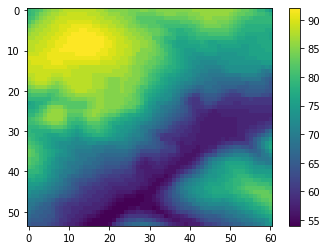

In [3]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [4]:
transformer = Transformer.from_crs("epsg:4326", "epsg:26917") # Latitude/Longitude to UTM
x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =transformer.transform(lat,lon)
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

## Load Well Time Series Data + Preprocess

In [5]:
# Load and process well time-series data
concentration_data = pd.read_csv('data/FASB_Data_thru_3Q2015.csv')
construction_data = pd.read_excel('data/FASB Well Construction Info.xlsx')
pylenm = functions(concentration_data)
pylenm.simplify_data(inplace=True)
pylenm.setConstructionData(construction_data)

Successfully imported the data!

Successfully imported the construction data!



Data summary for water table

In [6]:
WT_details = pylenm.get_analyte_details('DEPTH_TO_WATER')
WT_details

,Start Date,End Date,Date Range (days),Unique samples
Well Name,,,,
FSB 94D,1990-01-01,1990-10-08,280,4
FSB 95D,1990-01-01,1990-10-08,280,4
FSB 77,1990-01-01,2006-10-16,6132,122
FSB111C,1990-01-01,2006-10-17,6133,115
FSB105C,1990-01-01,2006-10-19,6135,127
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [7]:
n_samples = WT_details['Unique samples']
end_date = WT_details['End Date']
start_date = WT_details['Start Date']
well_names  = WT_details.index
well_enough = well_names[n_samples>20]

In [8]:
well_recent = well_names[end_date> datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
well_old    = well_names[start_date< datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [9]:
wt_interp = pylenm.interpolate_wells_by_analyte('DEPTH_TO_WATER', frequency='1M', rm_outliers=True, z_threshold=3)

Select the upper aquifer wells and the wells that have enough samples

52 wells


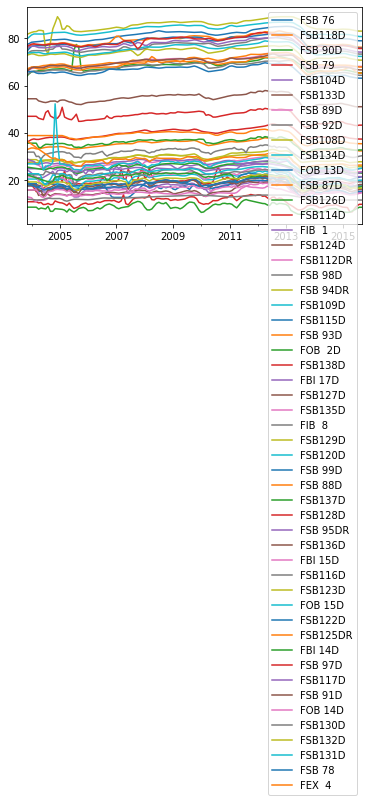

In [10]:
active = list(np.unique(pylenm.filter_by_column(pylenm.get_Construction_Data(), col='WELL_USE', equals=['ACTIVE']).index))
upper_wells = list(np.unique(pylenm.filter_by_column(pylenm.get_Construction_Data(), col='AQUIFER', equals=['UAZ_UTRAU']).index))
well_only_D = list(set(upper_wells) & set(wt_interp.columns)& set(well_enough)& set(well_recent)& set(well_old) & set(active))
wt_interp = wt_interp[well_only_D]
wt_interp.plot()
print(wt_interp.shape[1], "wells")

Let's remove the 'bad' time series wells

49 wells


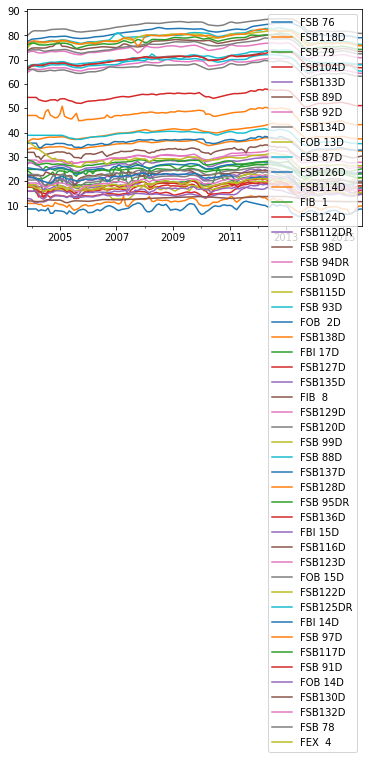

In [11]:
bad_ones = ['FSB108D', 'FSB131D', 'FSB 90D']
wt_interp = wt_interp.drop(columns=bad_ones)
wt_interp.plot()
print(wt_interp.shape[1], "wells")

In [12]:
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

# Convert to meters
wt_interp = wt_interp * 0.3048

In [13]:
wt_interp

,FBI 14D,FBI 15D,FBI 17D,FEX 4,FIB 1,FIB 8,FOB 2D,FOB 13D,FOB 14D,FOB 15D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 89D,FSB 91D,FSB 92D,FSB 93D,FSB 94DR,FSB 95DR,FSB 97D,FSB 98D,FSB 99D,FSB104D,FSB109D,FSB112DR,FSB114D,FSB115D,FSB116D,FSB117D,FSB118D,FSB120D,FSB122D,FSB123D,FSB124D,FSB125DR,FSB126D,FSB127D,FSB128D,FSB129D,FSB130D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
2003-11-30,6.799386,3.962976,7.476656,11.173978,7.576606,6.800403,7.790692,5.668502,4.851106,6.935652,23.574856,20.048542,6.147713,23.024472,20.180185,20.032287,20.109094,19.697527,20.415563,22.218396,23.226141,23.356402,22.421052,22.705002,6.056489,24.305091,8.128405,10.988755,5.333086,3.644943,8.855726,10.025387,22.477213,5.581415,8.251807,16.600459,11.851977,10.871707,4.832104,14.338075,8.747481,9.715958,5.875666,5.536697,6.246249,6.530004,5.359817,2.614448,3.314684
2003-12-31,6.696548,3.897743,7.256541,10.959825,7.576606,6.800403,7.745531,5.668502,4.851106,6.935652,23.722986,20.080563,5.729898,23.311720,20.454851,20.285825,20.380675,19.877116,20.566479,22.311360,23.295864,23.507608,22.618047,23.074745,5.712178,24.573653,8.503104,11.163206,5.388864,3.634179,8.716884,10.155778,22.505905,5.524030,8.358051,16.600459,11.851977,10.871707,4.832104,14.338075,8.747481,9.715958,5.875666,5.536697,6.246249,6.530004,5.359817,2.614448,3.314684
2004-01-31,6.592024,3.831440,7.032818,10.742162,7.576606,6.800403,7.699631,5.668502,4.851106,6.935652,23.888868,20.136348,5.469504,23.533386,20.685149,20.507368,20.599027,20.085509,20.667803,22.400142,23.371627,23.647725,22.769400,23.357518,5.450600,24.827446,8.407311,11.339026,5.411491,3.604969,8.622855,10.258389,22.552026,5.457426,8.441069,16.600459,11.851977,10.871707,4.832104,14.338075,8.747481,9.715958,5.875666,5.536697,6.246249,6.530004,5.359817,2.614448,3.314684
2004-02-29,6.490872,3.475863,6.629138,10.531519,7.576606,6.800403,7.655211,5.668502,4.851106,6.935652,23.927087,20.087288,5.121222,23.576715,20.726400,20.558688,20.682177,20.168326,20.618656,22.368986,23.414367,23.695986,22.803152,23.417445,5.275857,24.958652,8.270748,11.420113,5.359429,3.562334,8.503425,10.243174,22.582985,5.361275,8.437061,16.600459,11.851977,10.871707,4.832104,14.338075,8.747481,9.715958,5.875666,5.536697,6.246249,6.530004,5.359817,2.614448,3.314684
2004-03-31,6.389720,3.345216,6.382670,10.320877,7.576606,6.800403,7.610791,5.668502,4.851106,6.935652,23.950754,19.927630,4.618580,23.596310,20.726400,20.598492,20.654085,20.124783,20.519958,22.261830,23.311592,23.636224,22.810410,23.427605,5.015665,24.952158,8.113629,11.357543,5.273475,3.548743,8.186928,10.142607,22.545254,5.211377,8.351955,16.600459,11.851977,10.871707,4.832104,14.338075,8.747481,9.151620,5.875666,5.536697,6.246249,6.530004,5.359817,2.614448,3.314684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31,5.099585,4.416552,7.379208,8.003721,6.680686,5.934323,7.010400,6.220324,4.207035,6.078583,24.237366,19.388497,5.747048,23.444804,20.846415,20.720669,20.513405,19.814345,20.477451,21.737242,22.789148,23.267627,22.554765,23.333924,4.296229,24.801095,7.143508,11.480054,5.334000,3.535680,6.937811,10.042248,22.213407,4.409737,8.382416,15.678471,10.864654,9.994466,4.992204,13.255232,7.730158,9.029902,5.041838,4.645983,5.322521,5.495663,4.322618,2.119216,2.018187
2015-06-30,5.041955,4.500438,7.448931,8.020322,6.605911,5.904009,7.010400,6.332154,4.227235,6.088799,24.170365,19.335129,5.809268,23.361053,20.788312,20.740533,20.440305,19.742834,20.240171,21.677650,22.721618,23.191326,22.481721,23.251655,4.287212,24.735857,7.136946,11.445939,5.334000,3.535680,6.891476,9.978683,22.157788,4.487033,8.420446,15.600068,10.839220,9.960455,5.281586,13.167936,7.772812,9.036726,5.070181,4.734015,5.382887,5.722640,4.576156,2.270674,2.425557
2015-07-31,5.109635,4.584752,7.517709,8.036923,6.554861,5.883313,7.010400,6.417643,4.319186,6.095773

## Well Location Data

In [14]:
well_info = pylenm.get_Construction_Data()

Match the well indecies between the time series and locations

In [15]:
shared_wells = list(set(well_info.index) & set(wt_interp.columns))
wt_interp = wt_interp[shared_wells]
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [16]:
transformer = Transformer.from_crs("epsg:4326", "epsg:26917") # Latitude/Longitude to UTM
UTM_x, UTM_y = transformer.transform(well_info.LATITUDE, well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [17]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

# Now this is the water table elevation (GROUND_ELEVATION - DEPTH_TO_WATER)
wt_interp = elev.values - wt_interp

# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

In [18]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

In [19]:
wt_interp

,FBI 14D,FBI 15D,FBI 17D,FEX 4,FIB 1,FIB 8,FOB 2D,FOB 13D,FOB 14D,FOB 15D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 89D,FSB 91D,FSB 92D,FSB 93D,FSB 94DR,FSB 95DR,FSB 97D,FSB 98D,FSB 99D,FSB104D,FSB109D,FSB112DR,FSB114D,FSB115D,FSB116D,FSB117D,FSB118D,FSB120D,FSB122D,FSB123D,FSB124D,FSB125DR,FSB126D,FSB127D,FSB128D,FSB129D,FSB130D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
2003-11-30,61.585542,60.901512,60.688816,59.499998,62.295746,62.437965,62.008508,60.753514,61.54043,61.662636,66.158264,63.070418,60.298687,64.636008,65.925815,65.802441,65.140418,64.549193,63.876877,63.5127,63.458979,63.877358,64.325028,65.016438,60.816631,65.092749,61.987787,65.942765,58.278674,58.259937,61.522594,64.162933,63.052715,60.804025,64.382033,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2003-12-31,61.68838,60.966745,60.908931,59.714151,62.295746,62.437965,62.053669,60.753514,61.54043,61.662636,66.010134,63.038397,60.716502,64.34876,65.651149,65.548903,64.868837,64.369604,63.725961,63.419736,63.389256,63.726152,64.128033,64.646695,61.160942,64.824187,61.613088,65.768314,58.222896,58.270701,61.661436,64.032542,63.024023,60.86141,64.275789,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-01-31,61.792904,61.033048,61.132654,59.931814,62.295746,62.437965,62.099569,60.753514,61.54043,61.662636,65.844252,62.982612,60.976896,64.127094,65.420851,65.32736,64.650485,64.161211,63.624637,63.330954,63.313493,63.586035,63.97668,64.363922,61.42252,64.570394,61.708881,65.592494,58.200269,58.299911,61.755465,63.929931,62.977902,60.928014,64.192771,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-02-29,61.894056,61.388625,61.536334,60.142457,62.295746,62.437965,62.143989,60.753514,61.54043,61.662636,65.806033,63.031672,61.325178,64.083765,65.3796,65.27604,64.567335,64.078394,63.673784,63.36211,63.270753,63.537774,63.942928,64.303995,61.597263,64.439188,61.845444,65.511407,58.252331,58.342546,61.874895,63.945146,62.946943,61.024165,64.196779,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-03-31,61.995208,61.519272,61.782802,60.353099,62.295746,62.437965,62.188409,60.753514,61.54043,61.662636,65.782366,63.19133,61.82782,64.06417,65.3796,65.236236,64.595427,64.121937,63.772482,63.469266,63.373528,63.597536,63.93567,64.293835,61.857455,64.445682,62.002563,65.573977,58.338285,58.356137,62.191392,64.045713,62.984674,61.174063,64.281885,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,62.412372,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31,63.285343,60.447936,60.786264,62.670255,63.191666,63.304045,62.7888,60.201692,62.184501,62.519705,65.495754,63.730463,60.699352,64.215676,65.259585,65.114059,64.736107,64.432375,63.814989,63.993854,63.895972,63.966133,64.191315,64.387516,62.576891,64.596745,62.972684,65.451466,58.27776,58.3692,63.440509,64.146072,63.316521,61.975703,64.251424,63.389697,63.50045,63.08743,60.27462,62.69788,60.895562,62.53409,62.770066,62.516697,62.739319,62.203465,62.120734,59.840528,62.273277
2015-06-30,63.342973,60.36405,60.716541,62.653654,63.266441,63.334359,62.7888,60.089862,62.164301,62.509489,65.562755,63.783831,60.637132,64.299427,65.317688,65.094195,64.809207,64.503886,64.052269,64.053446,63.963502,64.042434,64.264359,64.469785,62.585908,64.661983,62.979246,65.485581,58.27776,58.3692,63.486844,64.209637,63.37214,61.898407,64.213394,63.4681,63.525884,63.121441,59.985238,62.785176,60.852908,62.527266,62.741723,62.428665,62.67895

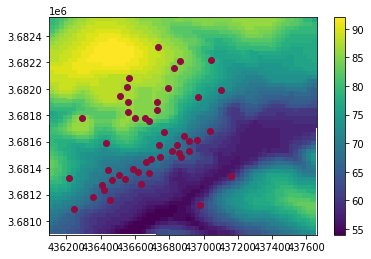

In [20]:
# Plotting the map
map_ = plt.pcolor(x_loc, y_loc , farea_dem)
plt.scatter(UTM_x, UTM_y, c='#900C3F')
plt.colorbar(map_)
plt.show()

In [21]:
wt_interp.head()

,FBI 14D,FBI 15D,FBI 17D,FEX 4,FIB 1,FIB 8,FOB 2D,FOB 13D,FOB 14D,FOB 15D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 89D,FSB 91D,FSB 92D,FSB 93D,FSB 94DR,FSB 95DR,FSB 97D,FSB 98D,FSB 99D,FSB104D,FSB109D,FSB112DR,FSB114D,FSB115D,FSB116D,FSB117D,FSB118D,FSB120D,FSB122D,FSB123D,FSB124D,FSB125DR,FSB126D,FSB127D,FSB128D,FSB129D,FSB130D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
2003-11-30,61.585542,60.901512,60.688816,59.499998,62.295746,62.437965,62.008508,60.753514,61.54043,61.662636,66.158264,63.070418,60.298687,64.636008,65.925815,65.802441,65.140418,64.549193,63.876877,63.5127,63.458979,63.877358,64.325028,65.016438,60.816631,65.092749,61.987787,65.942765,58.278674,58.259937,61.522594,64.162933,63.052715,60.804025,64.382033,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2003-12-31,61.68838,60.966745,60.908931,59.714151,62.295746,62.437965,62.053669,60.753514,61.54043,61.662636,66.010134,63.038397,60.716502,64.34876,65.651149,65.548903,64.868837,64.369604,63.725961,63.419736,63.389256,63.726152,64.128033,64.646695,61.160942,64.824187,61.613088,65.768314,58.222896,58.270701,61.661436,64.032542,63.024023,60.86141,64.275789,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-01-31,61.792904,61.033048,61.132654,59.931814,62.295746,62.437965,62.099569,60.753514,61.54043,61.662636,65.844252,62.982612,60.976896,64.127094,65.420851,65.32736,64.650485,64.161211,63.624637,63.330954,63.313493,63.586035,63.97668,64.363922,61.42252,64.570394,61.708881,65.592494,58.200269,58.299911,61.755465,63.929931,62.977902,60.928014,64.192771,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-02-29,61.894056,61.388625,61.536334,60.142457,62.295746,62.437965,62.143989,60.753514,61.54043,61.662636,65.806033,63.031672,61.325178,64.083765,65.3796,65.27604,64.567335,64.078394,63.673784,63.36211,63.270753,63.537774,63.942928,64.303995,61.597263,64.439188,61.845444,65.511407,58.252331,58.342546,61.874895,63.945146,62.946943,61.024165,64.196779,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-03-31,61.995208,61.519272,61.782802,60.353099,62.295746,62.437965,62.188409,60.753514,61.54043,61.662636,65.782366,63.19133,61.82782,64.06417,65.3796,65.236236,64.595427,64.121937,63.772482,63.469266,63.373528,63.597536,63.93567,64.293835,61.857455,64.445682,62.002563,65.573977,58.338285,58.356137,62.191392,64.045713,62.984674,61.174063,64.281885,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,62.412372,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678


In [22]:
XX = np.vstack([x_loc.flatten(), y_loc.flatten(), farea_dem.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation'])

In [23]:
dateRanges = wt_interp.index
values = {}
for date in dateRanges:
    values[date] = np.array(wt_interp.loc[date])

currentDate = dateRanges[20]
y = values[currentDate]

In [25]:
y_map, r_map, residuals, lr_trend = pylenm.interpolate_topo(X, y, XX, ft=['Elevation'], regression='linear', smooth=True)

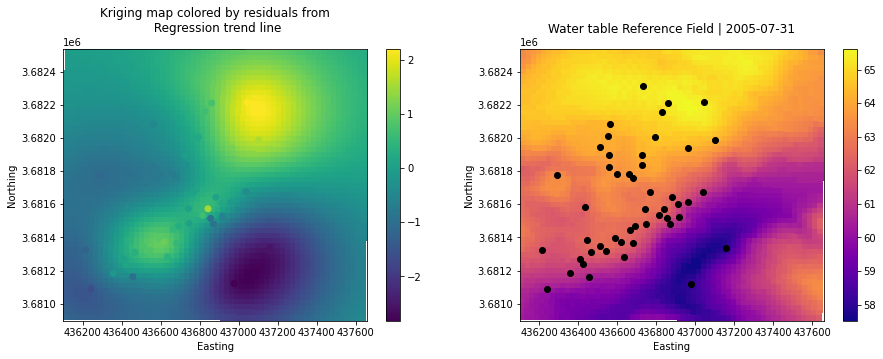

In [26]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5))
xx = np.array(XX)
titles = ["Kriging map colored by residuals from\n Regression trend line", str("Water table Reference Field | {}".format(currentDate.date()))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1])
colors=[residuals, 'black']
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04)
fig.show()

## STOPPED HERE

In [27]:
initial_wells = ['FSB 95DR','FSB130D','FSB 79', 'FSB 97D', 'FSB126D']
well_list = list(wt_interp.columns)
initial_idx = []
for i in initial_wells:
  initial_idx.append(well_list.index(i))
initial_indices = initial_idx.copy()
print(initial_idx)

[20, 41, 12, 21, 37]


In [29]:
max_wells = 20
selected_wells_idx, errors = pylenm.get_Best_Wells(X=X[['Easting','Northing']], y=y, xx=XX[['Easting','Northing']], ref=y_map, initial=initial_idx, max_wells=max_wells, ft=['Elevation'], regression='linear')

# of wells to choose from:  44
Selected well: 39 with a MSE error of 2.522283912125532

# of wells to choose from:  43
Selected well: 25 with a MSE error of 1.7008904314663698

# of wells to choose from:  42
Selected well: 32 with a MSE error of 1.5790400588804137

# of wells to choose from:  41
Selected well: 46 with a MSE error of 1.5041160391971282

# of wells to choose from:  40
Selected well: 45 with a MSE error of 1.4926718881974388

# of wells to choose from:  39
Selected well: 30 with a MSE error of 1.4901916791462435

# of wells to choose from:  38
Selected well: 33 with a MSE error of 1.4896529972504027

# of wells to choose from:  37
Selected well: 13 with a MSE error of 1.496607228157269

# of wells to choose from:  36
Selected well: 23 with a MSE error of 1.5000952074278664

# of wells to choose from:  35
Selected well: 42 with a MSE error of 1.4947158898128468

# of wells to choose from:  34
Selected well: 22 with a MSE error of 1.488966080803789

# of wells to choose fro

<AxesSubplot:>

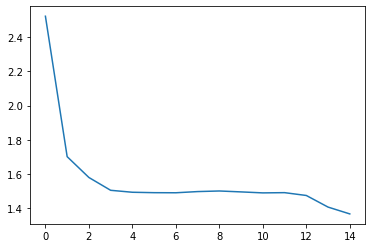

In [30]:
pd.Series(errors).plot()

In [32]:
pred_map, r_map, residuals, lr_trend = pylenm.interpolate_topo(X.iloc[selected_wells_idx], y[selected_wells_idx], XX, ft=['Elevation'], regression='linear', smooth=True)

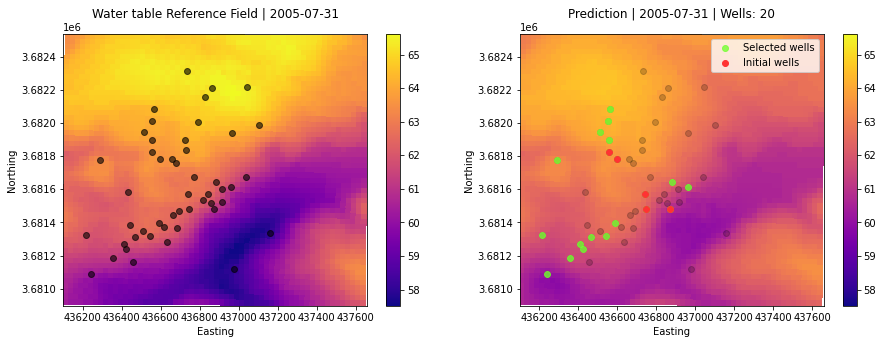

In [33]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5))
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format(currentDate.date())), str('Prediction | {} | Wells: {}'.format(currentDate.date(), max_wells))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape),
                cmap='plasma')
ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.6)
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                pred_map.reshape(x_loc.shape),
                cmap='plasma',
                vmin=y_map.min(), vmax=y_map.max())
ax[1].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.2)
ax[1].scatter(X.iloc[selected_wells_idx,0], X.iloc[selected_wells_idx,1], c='#75FF33', alpha=0.8, label='Selected wells')
ax[1].scatter(X.iloc[initial_indices,0], X.iloc[initial_indices,1], c='#FF3333', alpha=1, label='Initial wells')
ax[1].legend()
fig.colorbar(map_1, ax=ax[1])
for i in range(2):
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04)
fig.show()

In [34]:
print("Mean Squared Error: {:0.4f}".format(pylenm.mse(y_map, pred_map)))

Mean Squared Error: 1.2828


In [35]:
print("Selected wells:\n")
for i,j in zip(range(max_wells),selected_wells_idx): print(str(i+1) + ". " + well_list[j])

Selected wells:

1. FSB 95DR
2. FSB130D
3. FSB 79
4. FSB 97D
5. FSB126D
6. FSB128D
7. FSB109D
8. FSB120D
9. FSB136D
10. FSB135D
11. FSB117D
12. FSB122D
13. FSB 87D
14. FSB 99D
15. FSB132D
16. FSB 98D
17. FOB 15D
18. FOB 13D
19. FSB129D
20. FSB133D
